# Map options with px and folium for Dash

In [1]:
import pandas as pd
import json
import geopandas as gpd
import plotly.express as px
import chart_studio.plotly as py
import folium
import matplotlib.pyplot as plt
pd.options.display.max_columns=None

In [2]:
investments = pd.read_csv("../data/mintic_investments_clean.csv")

We remove the departments classified as national and international

In [3]:
investments_1 = investments.copy()
investments_1 = investments[~investments.departame_cod.isin(['0', 'in'])]
investments_1['departame_cod']= investments_1['departame_cod'].astype('int64')
investments_1.head(5) 

<ipython-input-3-6e9cdd4defc0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  investments_1['departame_cod']= investments_1['departame_cod'].astype('int64')


,anio_corte,fecha_corte,departame_nombre,departame_cod,municipio_nombre,municipio_cod,iniciativa,viceministerio,indicador,descripcion_indicador,inversion,beneficiarios,id
0,2020,2020-12-31,bogota,11,bogota_d.c.,11001,asesorias_en_teletrabajo,transformacion,numero_de_personas_impactadas_con_la_difusion_...,numero_de_personas_impactadas_con_la_difusion_...,773577049710,606,202011001
1,2020,2020-12-31,antioquia,5,medellin,5001,asesorias_en_teletrabajo,transformacion,numero_de_personas_impactadas_con_la_difusion_...,numero_de_personas_impactadas_con_la_difusion_...,114887680650,90,20205001
2,2020,2020-12-31,antioquia,5,apartado,5045,asesorias_en_teletrabajo,transformacion,numero_de_personas_impactadas_con_la_difusion_...,numero_de_personas_impactadas_con_la_difusion_...,70209138175,55,20205045
3,2020,2020-12-31,valle_del_cauca,76,cali,76001,asesorias_en_teletrabajo,transformacion,numero_de_personas_impactadas_con_la_difusion_...,numero_de_personas_impactadas_con_la_difusion_...,59996899895,47,202076001
4,2020,2020-12-31,cundinamarca,25,villapinzon,25873,asesorias_en_teletrabajo,transformacion,numero_de_personas_impactadas_con_la_difusion_...,numero_de_personas_impactadas_con_la_difusion_...,47231602045,37,202025873


Map with plotly express

we import the shp file from the dane geoportal

In [4]:
#all four files must be imported: .shp, .shx, .dbf, .prj of DANE Geoportal
mapa_colombia = gpd.read_file("/Users/SebastianGuzman/Desktop/MGN2020_DPTO_POLITICO/MGN_DPTO_POLITICO.shp")

mapa_colombia['DPTO_CCDGO'] = mapa_colombia['DPTO_CCDGO'].astype('int64')
mapa_colombia = mapa_colombia.sort_values('DPTO_CCDGO').reset_index().drop(columns='index')
dpto_nombres = investments_1[['departame_cod','departame_nombre']].drop_duplicates().sort_values('departame_cod').reset_index()['departame_nombre']
mapa_colombia['departame_nombre'] = dpto_nombres

print(type(mapa_colombia))
print(mapa_colombia.columns)
print(type(mapa_colombia.geometry))
print(mapa_colombia[['DPTO_CCDGO', 'departame_nombre']])

<class 'geopandas.geodataframe.GeoDataFrame'>
Index(['DPTO_CCDGO', 'DPTO_CNMBR', 'DPTO_ANO_C', 'DPTO_ACT_A', 'DPTO_NAREA',
       'DPTO_CSMBL', 'DPTO_VGNC', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry',
       'departame_nombre'],
      dtype='object')
<class 'geopandas.geoseries.GeoSeries'>
    DPTO_CCDGO    departame_nombre
0            5           antioquia
1            8           atlantico
2           11              bogota
3           13             bolivar
4           15              boyaca
5           17              caldas
6           18             caqueta
7           19               cauca
8           20               cesar
9           23             cordoba
10          25        cundinamarca
11          27               choco
12          41               huila
13          44          la_guajira
14          47           magdalena
15          50                meta
16          52             narinio
17          54  norte_de_santander
18          63             quindio
19          66

In [5]:
geo_map_col = json.loads(mapa_colombia.to_json())

In [69]:
def get_aggr_invest_by_year(year):
    '''
    This function gets the investment aggregated data along departments for a specific year
    '''
    dff = gpd.GeoDataFrame(
        investments_1[investments_1['anio_corte']==year].groupby(['departame_cod', 'departame_nombre', 'anio_corte']).sum().reset_index()\
            .merge(mapa_colombia[['DPTO_CCDGO', 'geometry']], left_on='departame_cod', right_on='DPTO_CCDGO')
    )
    return dff

In [32]:
#The dffs list will keep, for each year, a DataFrame of the Investment aggregated data:
dffs = []
for year in [2016,2017,2018,2019]:
    dffs.append([get_aggr_invest_by_year(year)])

In [14]:
# #Here we can see the syntax used for the creation of choropleth maps:

fig = px.choropleth_mapbox(dffs[0],                         #Data
        locations='departame_nombre',featureidkey="properties.departame_nombre", #Column containing the identifiers used in the GeoJSON file 
        color='inversion',   #Column giving the color intensity of the region
        geojson=geo_map_col,                          #The GeoJSON file
        zoom=3,                                   #Zoom
        mapbox_style="carto-positron",            #Mapbox style, for different maps you need a Mapbox account and a token
        center={"lat": 5, "lon": -72}, #Center
        color_continuous_scale="Viridis",         #Color Scheme
        projection='mercator'
        opacity=0.5,                              #Opacity of the map
        )

Map with folium

In [ ]:
investments_1['inversion_millions'] = investments_1['inversion']/1000000

dff = investments_1[investments_1['anio_corte']==2016].groupby(['departame_nombre', 'anio_corte']).sum().reset_index() #2016 map
#print(dff.head(10))

m = folium.Map(location=[5, -72], zoom_start=5, tiles='CartoDB positron')
folium.Choropleth(
    geo_data=geo_map_col,
    name="choropleth",
    data=dff,
    columns=["departame_nombre", "inversion_millions"],
    key_on="properties.departame_nombre",#"feature.id",
    fill_color="YlGn",
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name="Inversion (millions)",
).add_to(m)

folium.LayerControl().add_to(m)

m

## Non interactive plots for each year
The following graphs have the goal of showing the San Andrés and Providencia archipelago near the rest of the country, although sacrificing its interactivity. As such, these maps are also very light in required computational resources


In [ ]:
# First the polygons of San Andres and Providencia are separated from the rest of the country:
def divide_san_andres_providence(df):
    '''
    This function takes a DataFrame and separates San Andrés from the rest of the country. Then it further separates San Andrés and Providencia islands into its own DataFrames. 
    '''
    dff_no_san_andres = df[df['departame_cod']!=88]
    dff_san_andres = df[df['departame_cod']==88]
    dff_san_andres_isla = gpd.GeoDataFrame(dff_san_andres.explode().reset_index().drop(columns=['level_0', 'level_1']).loc[0:0])
    dff_providencia_isla = gpd.GeoDataFrame(dff_san_andres.explode().reset_index().drop(columns=['level_0', 'level_1']).loc[1:2])
    return dff_no_san_andres, dff_san_andres_isla, dff_providencia_isla

In [ ]:
# Here is applied the above function across every year and the resulting DataFrames (one for Colombia without San Andrés, other for San Andrés island and another for Providencia island)
# are appended to the dffs list:
for i in range(len(dffs)):
    dffs[i].append(divide_san_andres_providence(dffs[i][0]))

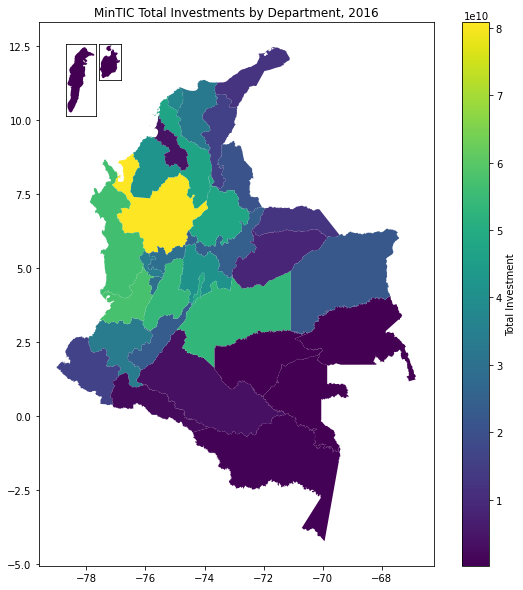

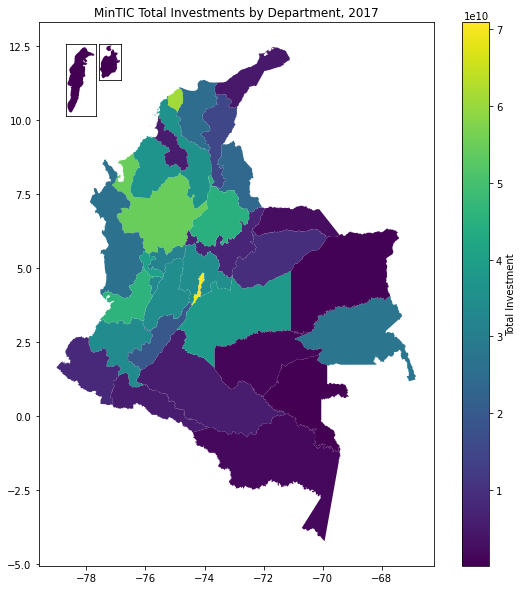

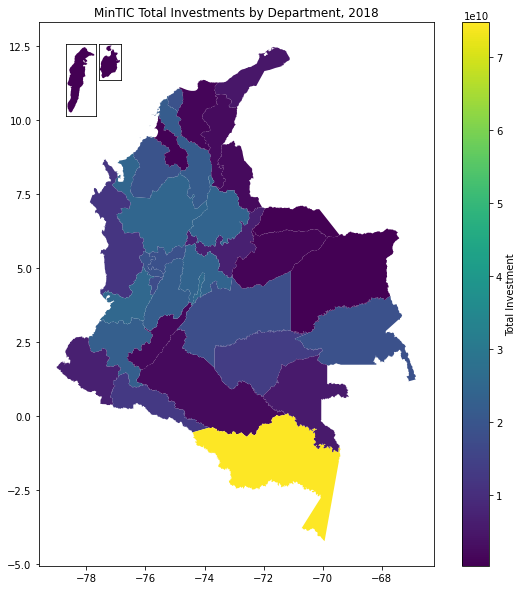

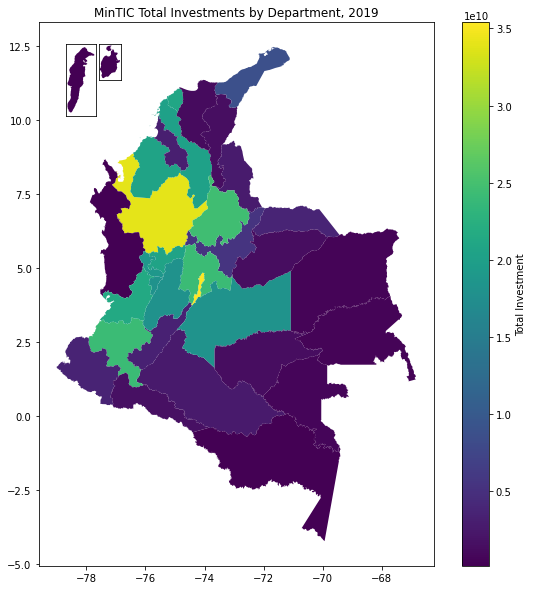

In [70]:
def plot_investment_year(list_of_dfs):
    '''
    Function to create non-interactive map plots of Colombia with two insets: one for San Andrés island and a second for Providencia island. These three maps should be in separate DataFrames inside a list
    '''
    fig = list_of_dfs[0].plot('inversion', figsize=(10,10), cmap='viridis', legend=True, legend_kwds={"label":"Total Investment"})
    plt.title('MinTIC Total Investments by Department, ' + str(list_of_dfs[0]['anio_corte'].unique()[0]))
    # San Andrés island inset:
    a = plt.axes([.23, .75, .05, .1])
    list_of_dfs[1].plot('inversion', cmap='viridis', ax=a)
    plt.xticks([])
    plt.yticks([])
    # Providencia island inset:
    b = plt.axes([.27, .8, .05, .05])
    list_of_dfs[2].plot('inversion', cmap='viridis', ax=b)
    plt.xticks([])
    plt.yticks([])
    return fig

# In the dffs list, the first index reffers to the year and has two objects: the original DataFrame of aggregated Investments for the year, and 
# a list with the three DataFrames from the `divide_san_andres_providence` function. Thus, 
for k in range(len(dffs)):
    plot_investment_year(dffs[k][1])